In [45]:
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
import mne

from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne import create_info
from mne.io import RawArray
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn

from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM


In [46]:
FILENAME = "/Users/rishabh/code/eeg/SPEAK_EEG/DATA/neurosity/visual-p300/2024_12_25_s01/rishabh_P300_02.csv"

df = pd.read_csv(FILENAME)


df.head


#List of file paths
# files = [
#     "/Users/aarooshbalakrishnan/Desktop/P300/venv/AAROOSH5.csv",
#     "/Users/aarooshbalakrishnan/Desktop/P300/venv/AAROOSH4.csv",
#     "/Users/aarooshbalakrishnan/Desktop/P300/venv/AAROOSH3.csv"
# ]

# # Read and concatenate all CSV files
# df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)




<bound method NDFrame.head of        EEG Channel 1  EEG Channel 2  EEG Channel 3  EEG Channel 4  \
0      -32002.375000   24199.761719  194540.625000   12673.236328   
1      -31710.953125   25818.609375  198430.687500   15089.839844   
2      -31621.367188   26915.095703  205806.765625   17297.767578   
3      -31885.363281   25449.738281  202754.890625   15197.865234   
4      -32028.056641   24176.158203  195459.015625   12768.455078   
...              ...            ...            ...            ...   
19854  -25948.830078   18152.519531  220334.546875   28528.578125   
19855  -25926.568359   18414.302734  225835.218750   29277.183594   
19856  -26082.269531   17677.701172  222478.578125   27772.330078   
19857  -26139.400391   17264.574219  216590.593750   26750.273438   
19858  -25983.498047   17909.980469  218407.656250   27979.798828   

       EEG Channel 5  EEG Channel 6  EEG Channel 7  EEG Channel 8  Marker  
0      117322.234375   300018.56250  -17827.570312  -21439.031250

In [47]:
# df = df.drop(["1-31"], axis=1)
df.columns = ["CP3", "C3", "F5", "PO3", "PO4", "F6", "C4", "CP4", "Marker"]

df.head()

,CP3,C3,F5,PO3,PO4,F6,C4,CP4,Marker
0,-32002.375000,24199.761719,194540.625000,12673.236328,117322.234375,300018.56250,-17827.570312,-21439.031250,0.0
1,-31710.953125,25818.609375,198430.687500,15089.839844,119983.460938,302657.37500,-17525.017578,-20414.427734,0.0
2,-31621.367188,26915.095703,205806.765625,17297.767578,122687.125000,309311.40625,-17412.029297,-19752.255859,0.0
3,-31885.363281,25449.738281,202754.890625,15197.865234,120419.382812,307777.71875,-17681.322266,-20657.300781,0.0
4,-32028.056641,24176.158203,195459.015625,12768.455078,117502.148438,301033.56250,-17848.625000,-21455.324219,0.0


In [48]:
def df_to_raw(df):
    sfreq = 256  #our Neurosity headset sampling rate
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T 
    df[:-1] *= 1e-6  #convert from uVolts to Volts 

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)

    #plotting power spectral density
    raw.compute_psd().plot()

    return raw
raw = df_to_raw(df)

Creating RawArray with float64 data, n_channels=9, n_times=19859
    Range : 0 ... 19858 =      0.000 ...    77.570 secs
Ready.
Effective window size : 8.000 (s)


In [49]:
raw.filter(1,18, method='iir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 18.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,"8 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,1.00 Hz
Lowpass,18.00 Hz


In [50]:
from mne import Epochs, find_events

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs

In [51]:
event_id = {'Non-Target': 1, 'Target' : 2} #changed nontarget from 1 to 0
tmin = -0.1 # tmin and tmax are changeable so we can always do that
tmax = 0.6 
eeg_channels = mne.pick_types(raw.info, eeg=True)
picks= eeg_channels
epochs = getEpochs(raw, event_id, tmin, tmax, picks)

100 events found on stim channel Marker
Event IDs: [1 2]


sample drop %:  1.0000000000000009


In [52]:
print(len(epochs))


99


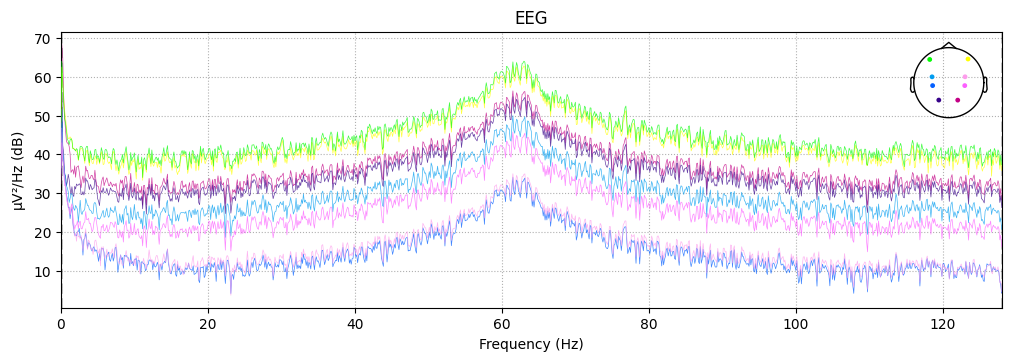

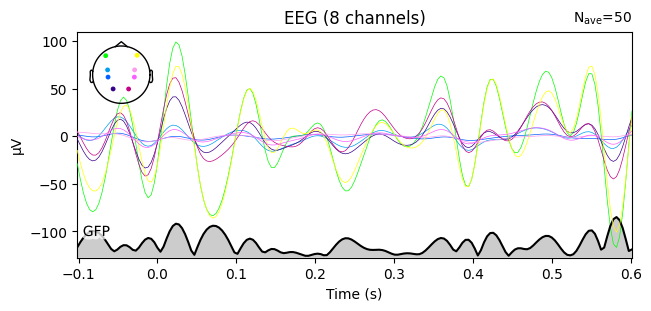

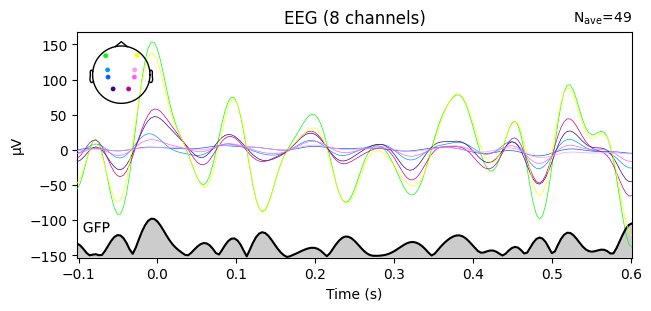

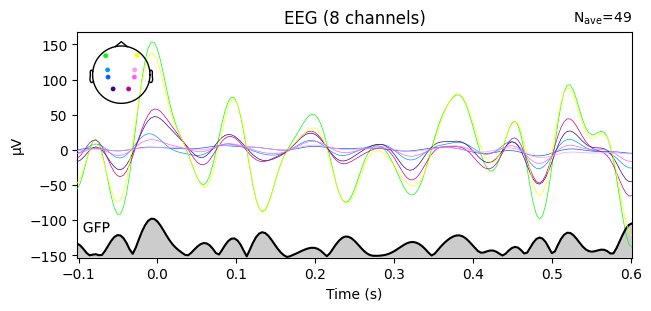

In [53]:
#ERP plots
evoked_non = epochs['Non-Target'].average()
evoked_non.plot(spatial_colors=True, gfp=True, time_unit='s')
evoked_target = epochs['Target'].average()
evoked_target.plot(spatial_colors=True, gfp=True, time_unit='s')

# #topogrophies
# times = np.linspace(-0.1, 0.6, 5)
# evoked_non.plot_topomap(ch_type='eeg', times=times, colorbar=True)
# evoked_target.plot_topomap(ch_type='eeg', times=times, colorbar=True)
# evoked_non.plot_joint(times=times)
# evoked_target.plot_joint(times=times)

#Comparison between target and nontarget
# def custom_func(x):
#     return x.max(axis=1)

# total_evoked = {"non": evoked_non, "target": evoked_target}
# # for combine in ('mean', 'median', 'gfp', custom_func):
# mne.viz.plot_compare_evokeds(total_evoked, picks=[0,1,2,3,4,5,6,7], combine='mean',
#                              colors=dict(non=0, target=1),
#                              linestyles=dict(non='solid', target='dashed'),
#                              styles=dict(non=dict(linewidth=2),target=dict(linewidth=3))) 

Non-target data shape for channel CP3: (50, 1, 181)
Target data shape for channel CP3: (49, 1, 181)


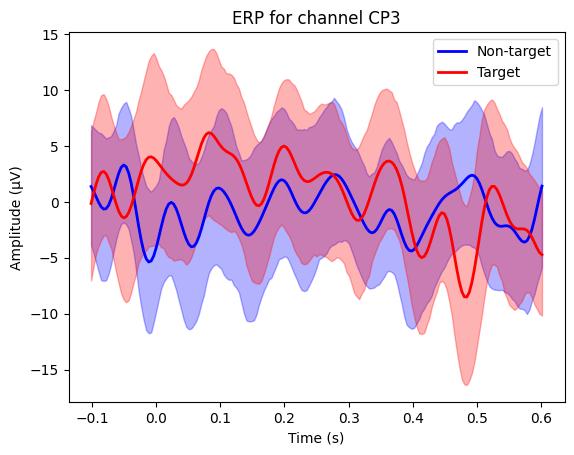

Non-target data shape for channel C3: (50, 1, 181)
Target data shape for channel C3: (49, 1, 181)


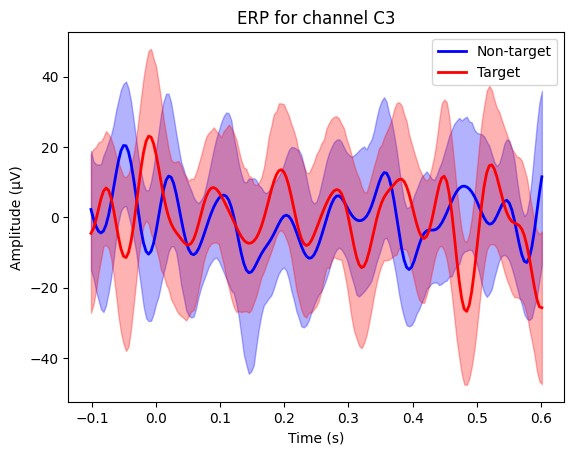

Non-target data shape for channel F5: (50, 1, 181)
Target data shape for channel F5: (49, 1, 181)


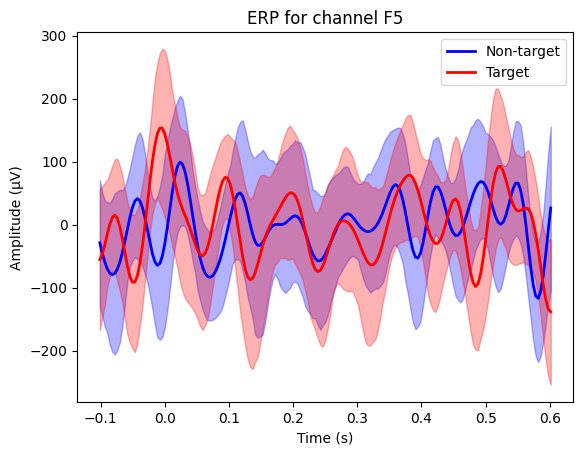

Non-target data shape for channel PO3: (50, 1, 181)
Target data shape for channel PO3: (49, 1, 181)


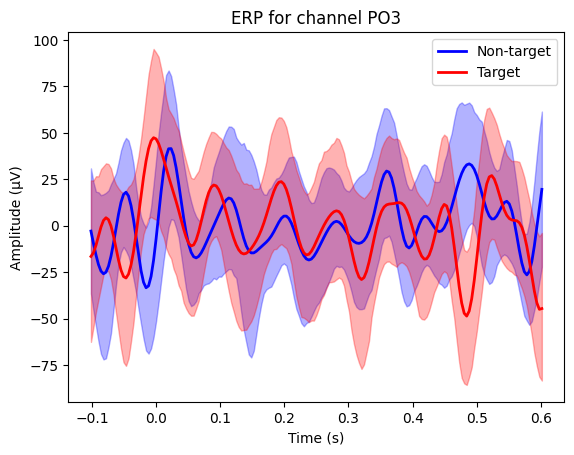

Non-target data shape for channel PO4: (50, 1, 181)
Target data shape for channel PO4: (49, 1, 181)


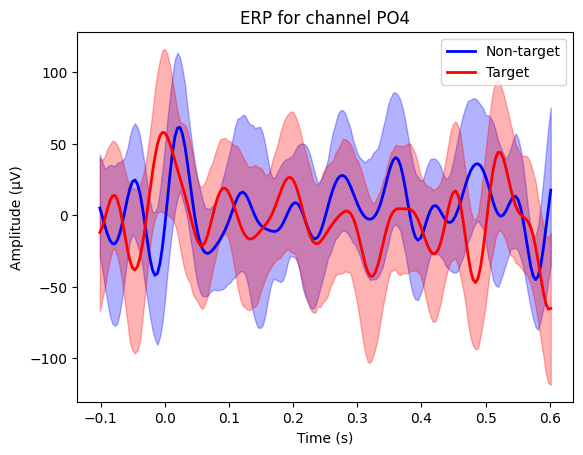

Non-target data shape for channel F6: (50, 1, 181)
Target data shape for channel F6: (49, 1, 181)


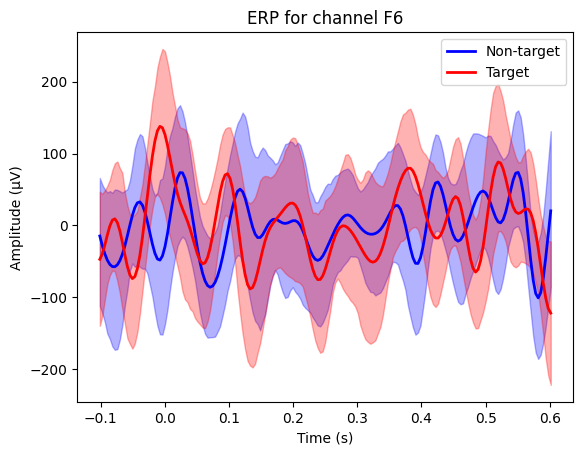

Non-target data shape for channel C4: (50, 1, 181)
Target data shape for channel C4: (49, 1, 181)


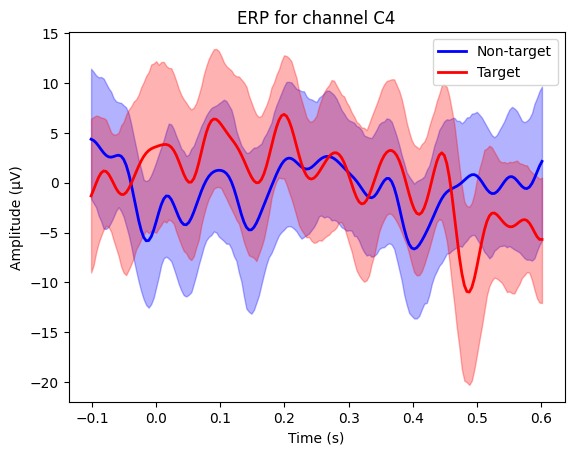

Non-target data shape for channel CP4: (50, 1, 181)
Target data shape for channel CP4: (49, 1, 181)


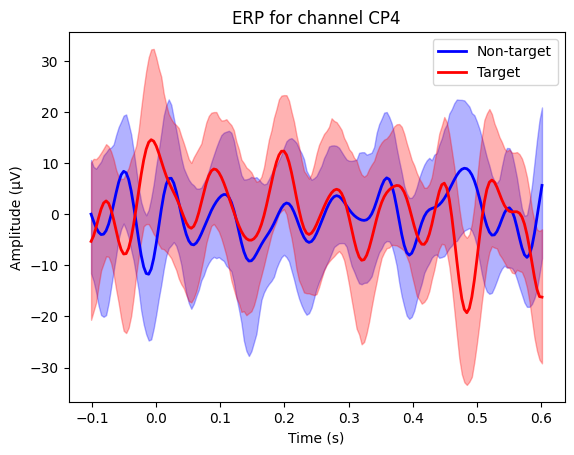

In [54]:
# Function to compute confidence intervals for each channel
def bootstrap_ci_per_channel(data, ci=95, n_bootstraps=1000):
    """
    Compute bootstrap confidence intervals for each channel independently.

    Parameters:
        data (numpy.ndarray): Shape (n_trials, n_channels, n_times)
        ci (float): Confidence interval percentage (default: 95)
        n_bootstraps (int): Number of bootstrap iterations (default: 1000)

    Returns:
        lower_bounds (numpy.ndarray): Lower bounds of CI for each channel (n_channels, n_times)
        upper_bounds (numpy.ndarray): Upper bounds of CI for each channel (n_channels, n_times)
    """
    if data.ndim == 2:  # If data has shape (n_trials, n_times), add a channel dimension
        data = data[:, np.newaxis, :]  # Shape becomes (n_trials, 1, n_times)

    n_trials, n_channels, n_times = data.shape
    lower_bounds = np.zeros((n_channels, n_times))
    upper_bounds = np.zeros((n_channels, n_times))
    
    for ch in range(n_channels):
        # Bootstrap for the current channel
        bootstrapped_means = []
        for _ in range(n_bootstraps):
            # Randomly sample with replacement from trials
            boot_sample = np.random.choice(np.arange(n_trials), size=n_trials, replace=True)
            boot_mean = np.mean(data[boot_sample, ch, :], axis=0)
            bootstrapped_means.append(boot_mean)
        bootstrapped_means = np.array(bootstrapped_means)

        # Compute the confidence intervals (percentiles) across time points
        lower_bounds[ch, :] = np.percentile(bootstrapped_means, (100 - ci) / 2, axis=0)
        upper_bounds[ch, :] = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2, axis=0)

    return lower_bounds, upper_bounds

channel_names = evoked_non.info['ch_names'][:8]  # Assuming the first 8 channels are EEG channels

for i, ch_name in enumerate(channel_names):
    fig, ax = plt.subplots()

    # Get the data for both target and non-target conditions using channel names
    non_target_data = epochs['Non-Target'].get_data(picks=ch_name) * 1e6  # Scale to microvolts
    target_data = epochs['Target'].get_data(picks=ch_name) * 1e6

    # Ensure the data is 3D with shape (n_trials, n_channels, n_times)
    if non_target_data.ndim == 2:
        non_target_data = non_target_data[:, np.newaxis, :]  # Add a channel dimension
    if target_data.ndim == 2:
        target_data = target_data[:, np.newaxis, :]

    # Debug: print data shapes
    print(f"Non-target data shape for channel {ch_name}: {non_target_data.shape}")
    print(f"Target data shape for channel {ch_name}: {target_data.shape}")
    
    # Compute confidence intervals using bootstrapping
    non_lower, non_upper = bootstrap_ci_per_channel(non_target_data)
    target_lower, target_upper = bootstrap_ci_per_channel(target_data)

    # Plot the average ERP for the non-target and target conditions
    ax.plot(evoked_non.times, evoked_non.data[i] * 1e6, label='Non-target', color='blue', linewidth=2)
    ax.fill_between(evoked_non.times, non_lower[0], non_upper[0], color='blue', alpha=0.3)

    ax.plot(evoked_target.times, evoked_target.data[i] * 1e6, label='Target', color='red', linewidth=2)
    ax.fill_between(evoked_target.times, target_lower[0], target_upper[0], color='red', alpha=0.3)

    # Set plot details
    ax.set_title(f'ERP for channel {ch_name}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (µV)')
    ax.legend()
    plt.show()

In [55]:
print("Non-Target Channels:", epochs['Non-Target'].info['ch_names'])
print("Target Channels:", epochs['Target'].info['ch_names'])


Non-Target Channels: ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']
Target Channels: ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']


In [56]:
# import numpy as np

# # Function to reject bad trials based on std threshold per channel
# def reject_trials_using_std_per_channel(epochs, percentile=75):
#     """
#     Reject trials based on a standard deviation threshold that retains approximately 75% of the trials.
#     This is done for each channel individually.
#     """
#     data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
#     n_channels = data.shape[1]
    
#     # Store bad trials for each channel
#     bad_trials = set()
    
#     # Loop through each channel
#     for ch in range(n_channels):
#         # Compute the standard deviation across time points for each trial (for this channel)
#         trial_std = np.std(data[:, ch, :], axis=1)  # Shape: (n_epochs,)
        
#         # Determine the threshold that retains 75% of the trials for this channel
#         threshold = np.percentile(trial_std, percentile)
        
#         # Identify bad trials where the std exceeds the threshold for this channel
#         bad_trials.update(np.where(trial_std > threshold)[0])
    
#     # Drop the bad trials
#     clean_epochs = epochs.copy()
#     for bad_epoch in sorted(bad_trials, reverse=True):  # Reverse to avoid index issues when dropping
#         clean_epochs.drop([bad_epoch])
    
#     # Return cleaned epochs and the number of trials before and after rejection
#     return clean_epochs, len(epochs), len(clean_epochs)

# # Apply the rejection for both target and non-target epochs based on std (retain 75%)
# clean_epochs_non_target, n_trials_before_non, n_trials_after_non = reject_trials_using_std_per_channel(epochs['Non-Target'], percentile=75)
# clean_epochs_target, n_trials_before_target, n_trials_after_target = reject_trials_using_std_per_channel(epochs['Target'], percentile=75)

# # Print the number of trials before and after rejection to confirm
# print(f"Non-Target Trials: Before = {n_trials_before_non}, After = {n_trials_after_non}")
# print(f"Target Trials: Before = {n_trials_before_target}, After = {n_trials_after_target}")


In [57]:
import numpy as np
import numpy as np

def reject_trials_using_std_per_channel(epochs, percentile=75):
    """
    Reject trials based on a standard deviation threshold for each channel independently.
    Retains trials based on the given percentile threshold.
    
    Parameters:
        epochs: mne.Epochs
            The epochs object containing the EEG data.
        percentile: float
            The percentile threshold (e.g., 75 means keeping trials within the 75th percentile).
            
    Returns:
        clean_epochs: mne.Epochs
            The epochs object after rejecting bad trials.
        n_trials_before: int
            The number of trials before rejection.
        n_trials_after: int
            The number of trials after rejection.
    """
    data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
    n_channels = data.shape[1]
    n_epochs = data.shape[0]

    # Initialize a boolean mask for good trials
    good_trials = np.ones(n_epochs, dtype=bool)

    # Loop through each channel
    for ch in range(n_channels):
        # Compute the standard deviation across time points for each trial (for this channel)
        trial_std = np.std(data[:, ch, :], axis=1)  # Shape: (n_epochs,)

        # Determine the threshold based on the given percentile
        threshold = np.percentile(trial_std, percentile)

        # Mark trials exceeding the threshold as bad for this channel
        channel_good_trials = trial_std <= threshold

        # Retain only trials that are good across all channels
        good_trials &= channel_good_trials

    # Create a cleaned epochs object by retaining only the good trials
    clean_epochs = epochs[good_trials]

    # Return cleaned epochs and the number of trials before and after rejection
    return clean_epochs, n_epochs, len(clean_epochs)
# Apply the rejection for Non-Target epochs with a 75th percentile threshold
clean_epochs_non_target, n_trials_before_non, n_trials_after_non = reject_trials_using_std_per_channel(
    epochs['Non-Target'], percentile=30
)

# Apply the rejection for Target epochs with a 55th percentile threshold
clean_epochs_target, n_trials_before_target, n_trials_after_target = reject_trials_using_std_per_channel(
    epochs['Target'], percentile=25
)

# Print results
print(f"Non-Target Trials: Before = {n_trials_before_non}, After = {n_trials_after_non}")
print(f"Target Trials: Before = {n_trials_before_target}, After = {n_trials_after_target}")


Non-Target Trials: Before = 50, After = 2
Target Trials: Before = 49, After = 3


In [58]:
def print_channels(evoked_target, evoked_nontarget):
    """
    Print all the channel names from both target and non-target evoked data.
    """
    target_channels = evoked_target.info['ch_names']
    nontarget_channels = evoked_nontarget.info['ch_names']

    print("Target Channels:", target_channels)
    print("Non-Target Channels:", nontarget_channels)


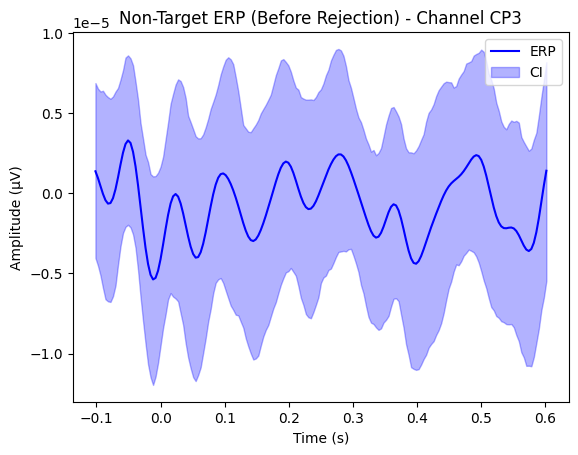

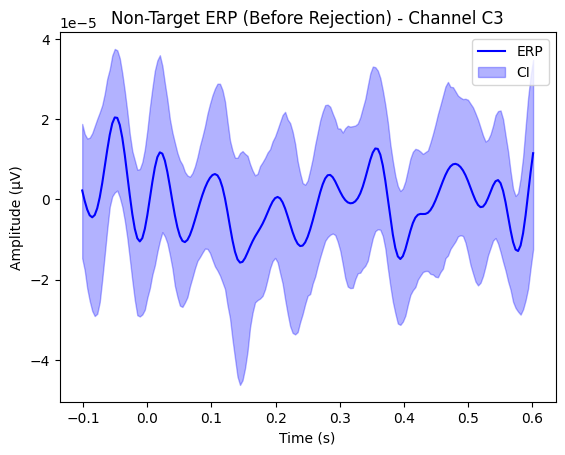

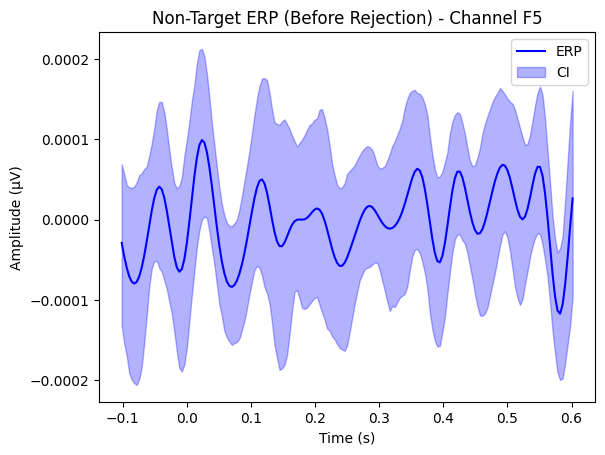

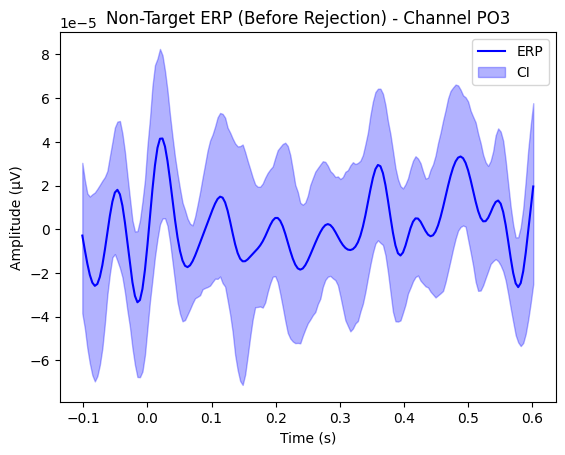

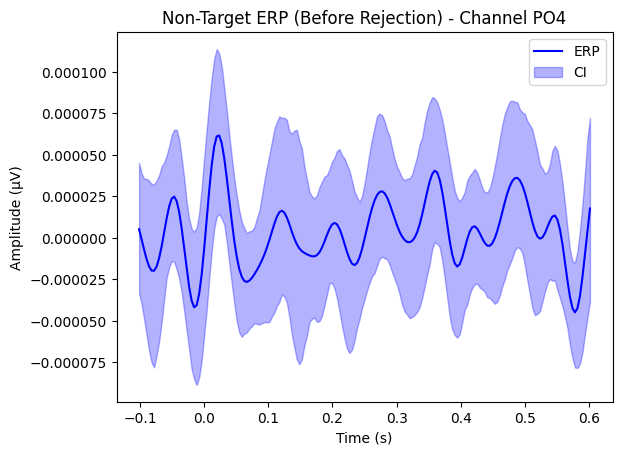

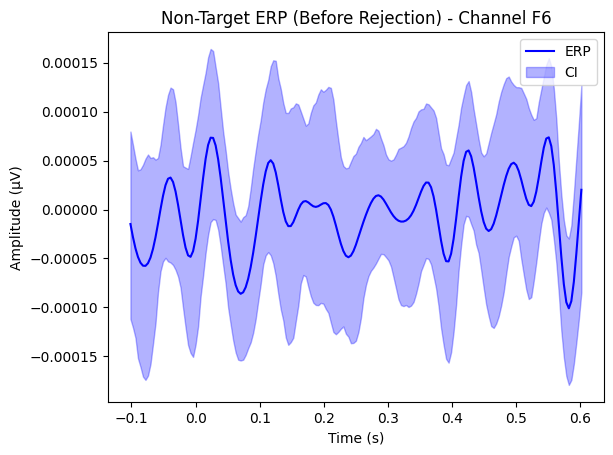

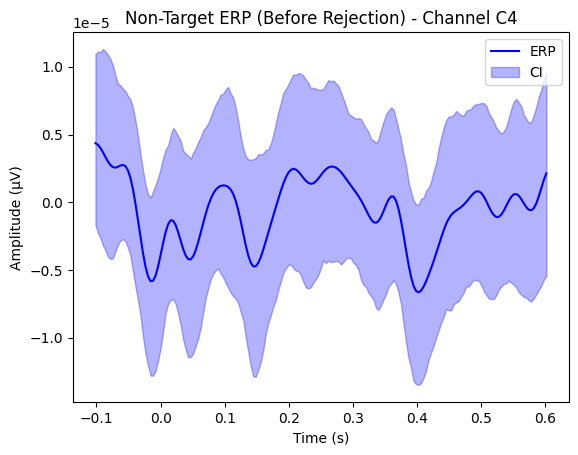

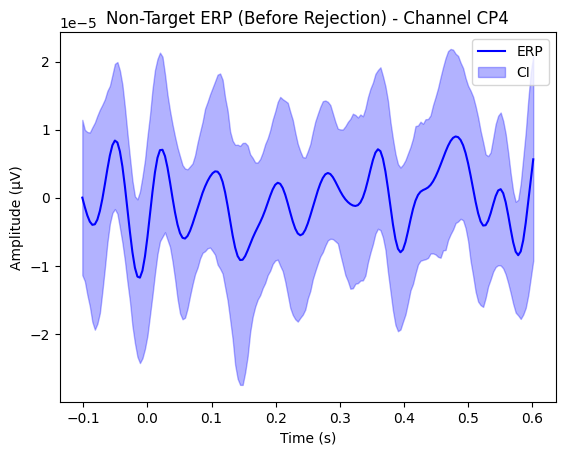

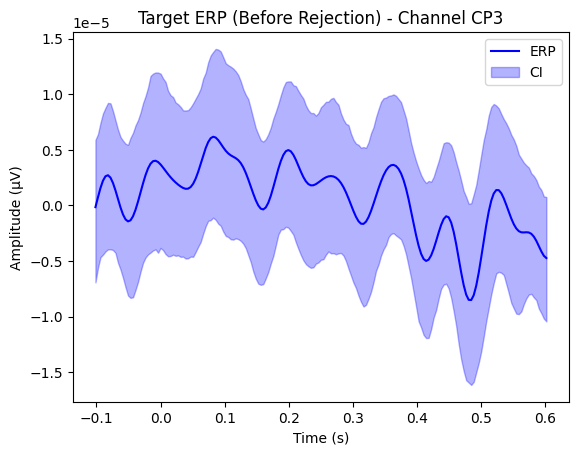

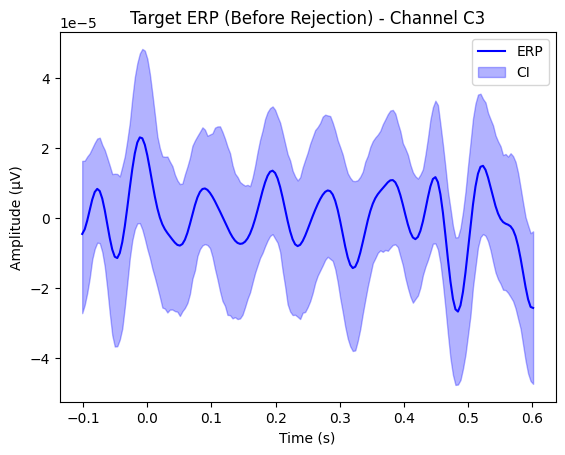

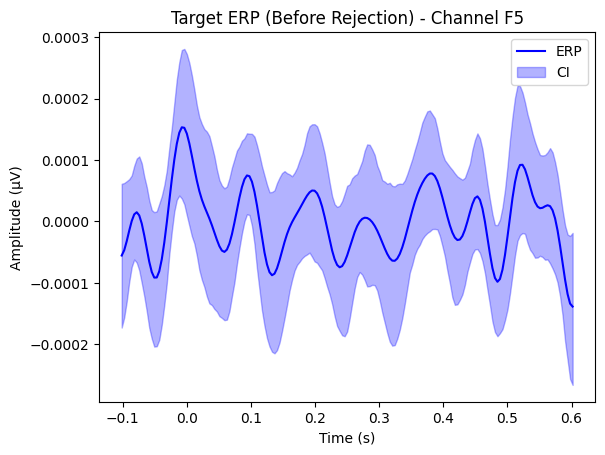

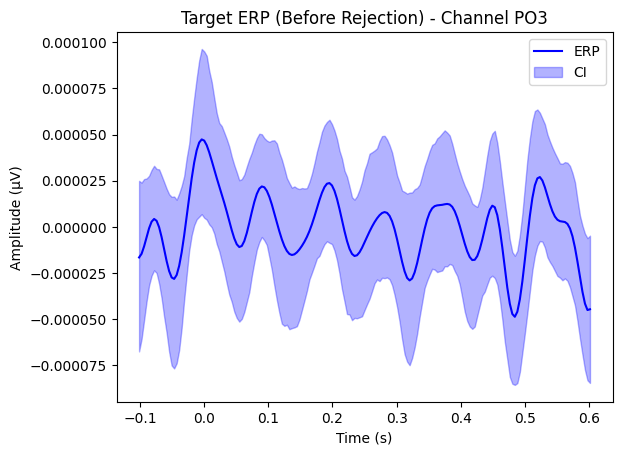

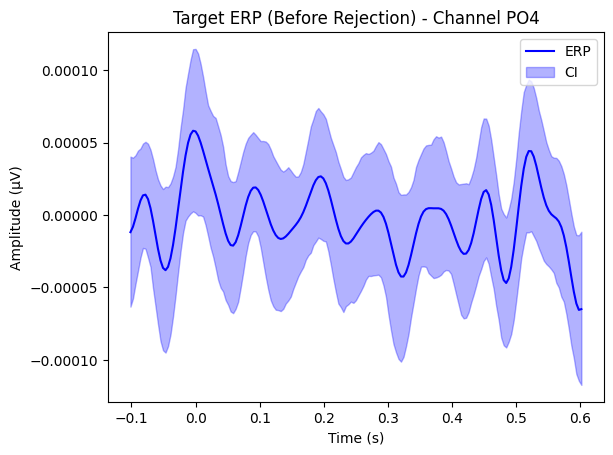

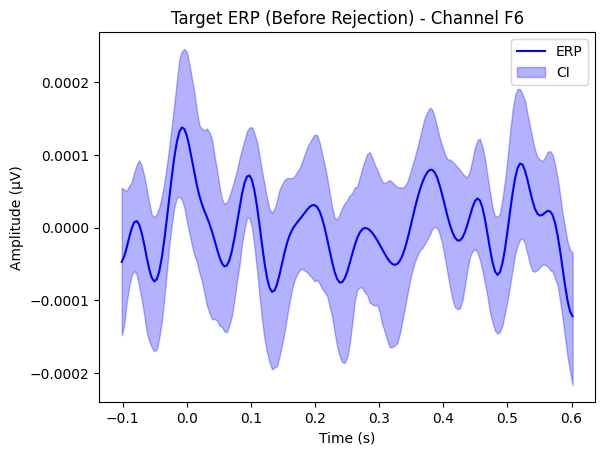

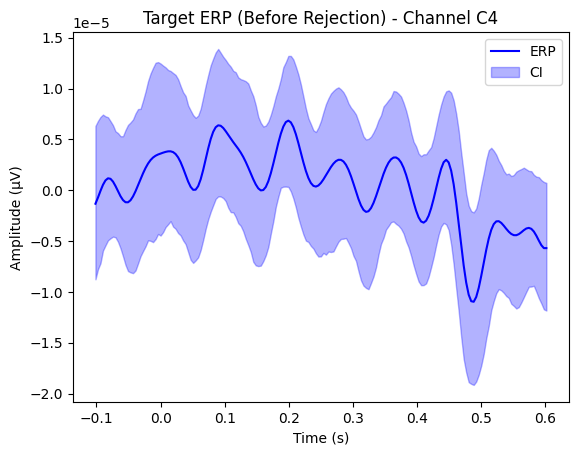

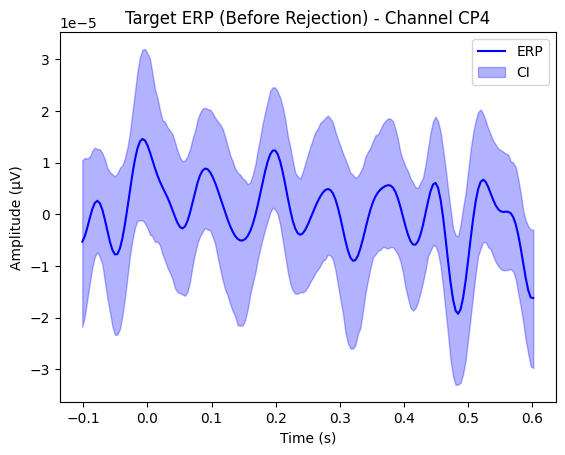

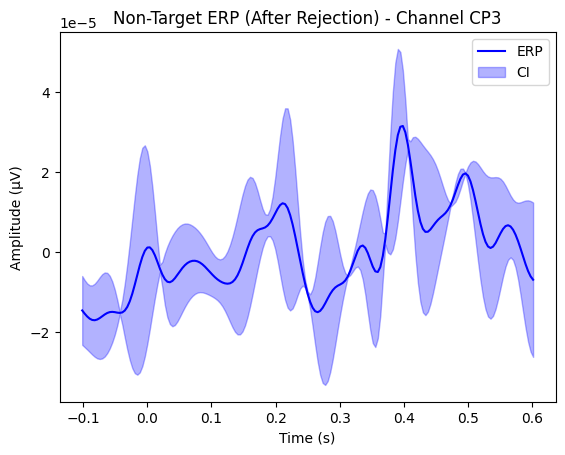

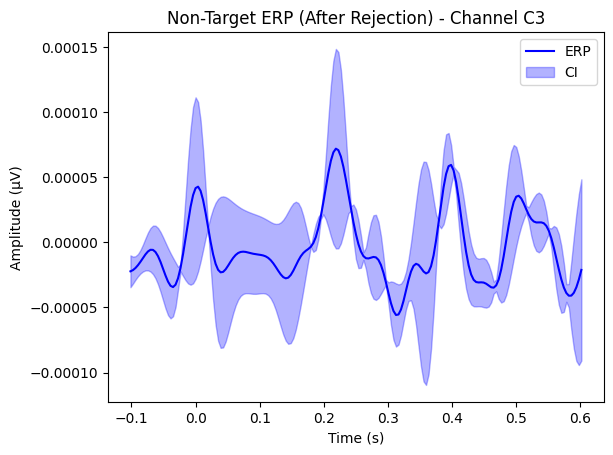

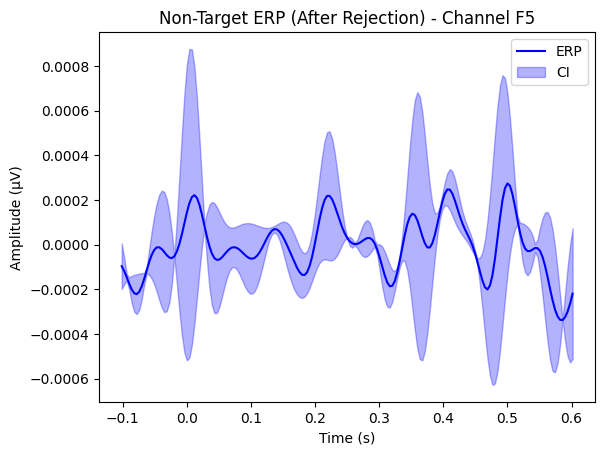

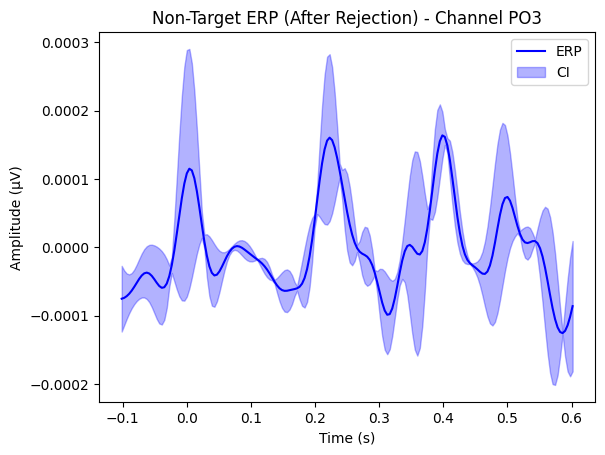

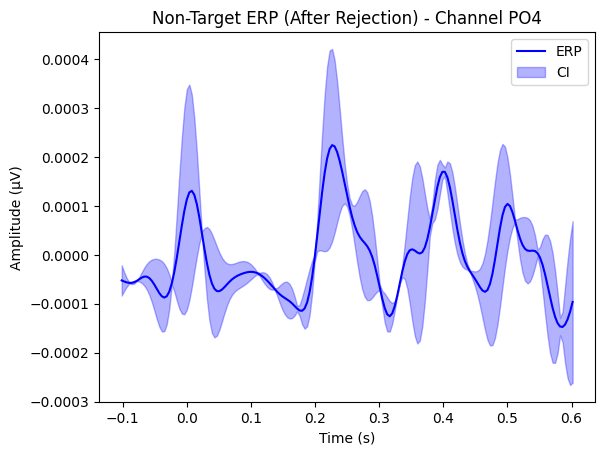

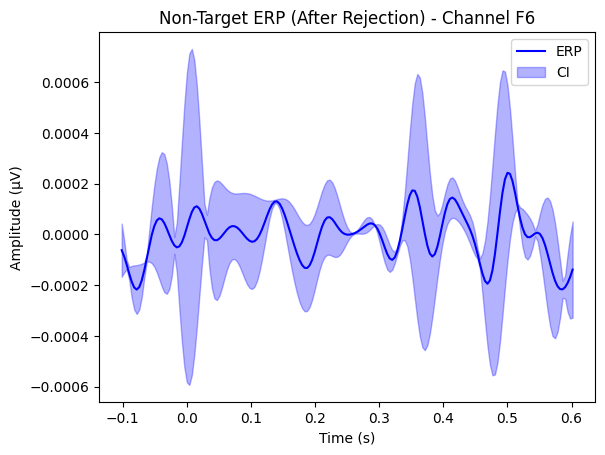

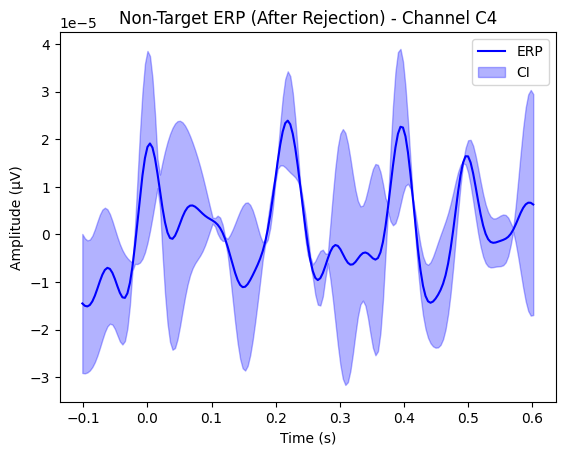

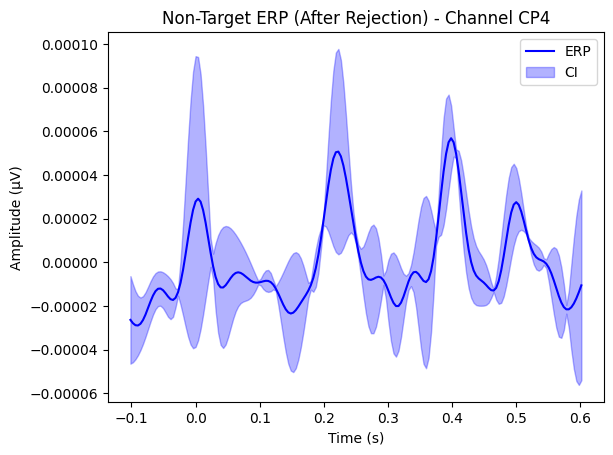

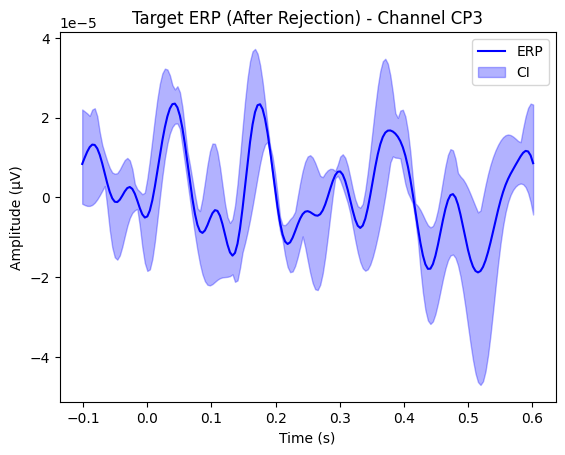

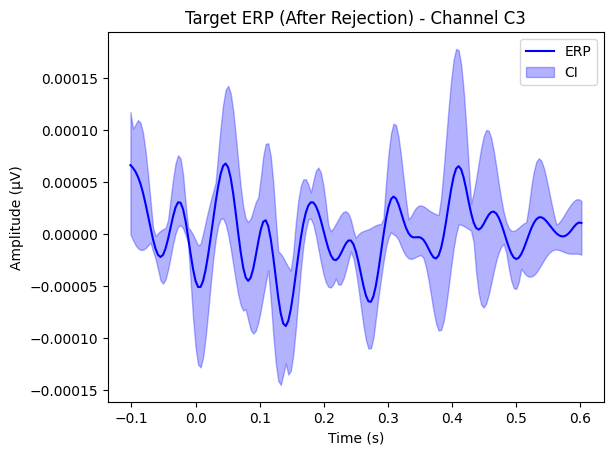

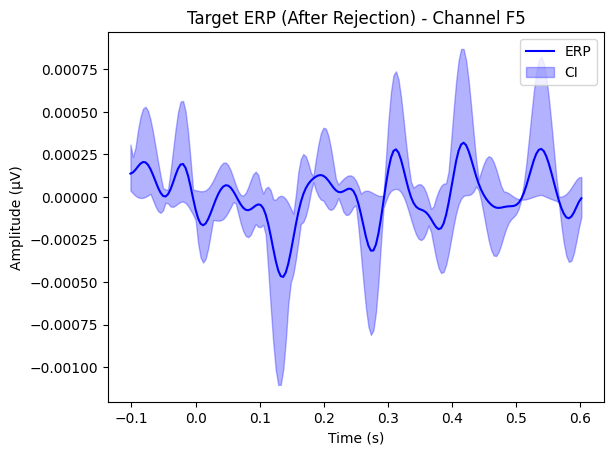

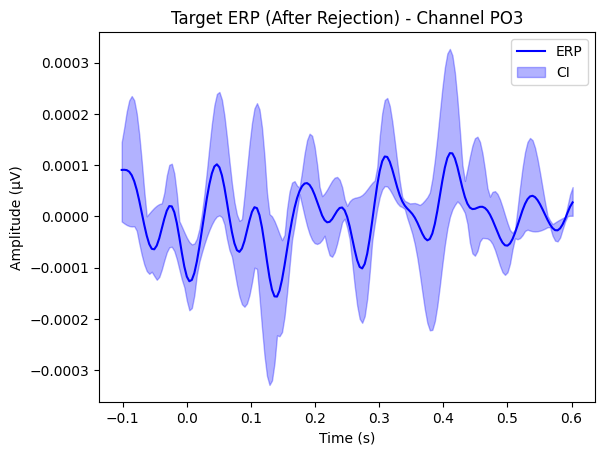

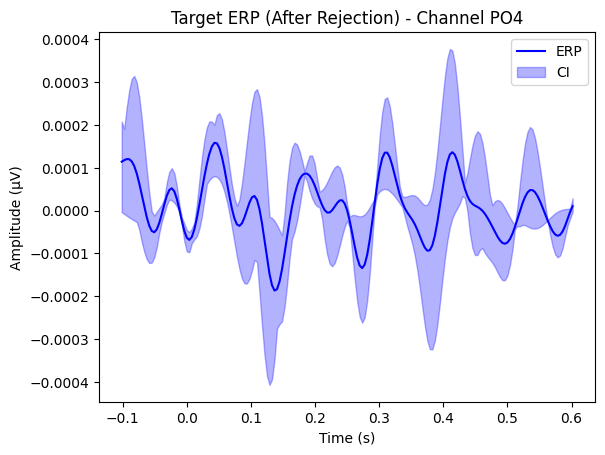

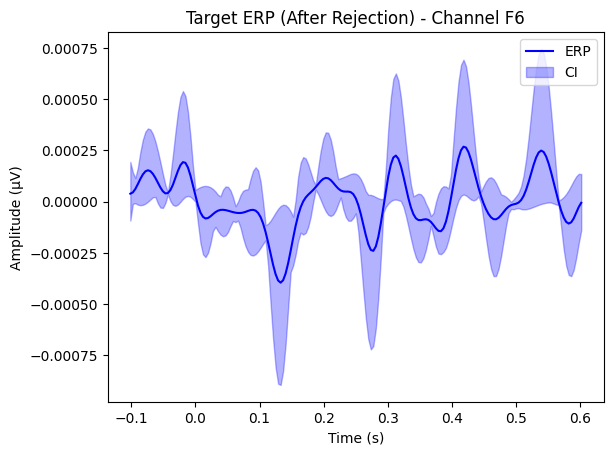

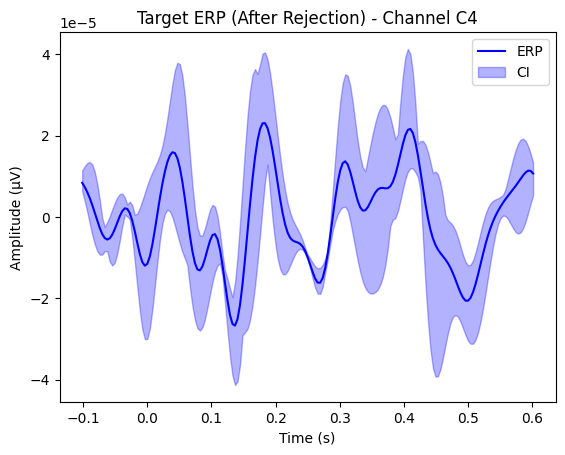

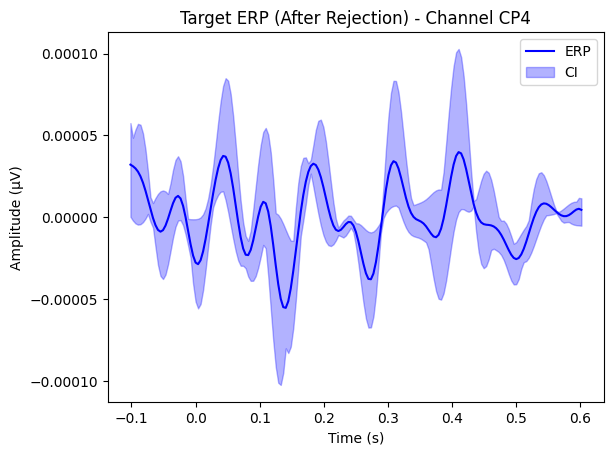

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute Confidence Intervals using Bootstrapping
def bootstrap_ci(data, ci=95, n_bootstraps=1000):
    """
    Compute confidence intervals using bootstrapping for each channel.
    """
    bootstrapped_means = []
    n_trials, n_times = data.shape

    for _ in range(n_bootstraps):
        boot_sample = np.random.choice(np.arange(n_trials), size=n_trials, replace=True)
        boot_mean = np.mean(data[boot_sample, :], axis=0)
        bootstrapped_means.append(boot_mean)

    bootstrapped_means = np.array(bootstrapped_means)
    lower_bound = np.percentile(bootstrapped_means, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2, axis=0)

    return lower_bound, upper_bound

# Function to plot ERP with Confidence Intervals for each channel
def plot_erp_with_ci_per_channel(evoked_data, epochs, title, ci=95):
    """
    Plot ERP with confidence intervals for each channel without interpolation.
    """
    data = epochs.get_data()  # Extract epochs data
    times = evoked_data.times  # Extract time points

    # Loop through each channel and plot the ERP and Confidence Interval
    for i, ch_name in enumerate(evoked_data.info['ch_names']):
        # Compute confidence intervals for the current channel
        lower_ci, upper_ci = bootstrap_ci(data[:, i, :])

        # Plot ERP and confidence intervals for this channel
        plt.figure()
        plt.plot(times, evoked_data.data[i], label='ERP', color='blue')
        plt.fill_between(times, lower_ci, upper_ci, color='blue', alpha=0.3, label='CI')
        plt.title(f'{title} - Channel {ch_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.legend()
        plt.show()

# Assuming the epochs are cleaned and bad epochs are removed
# For example: clean_epochs_non_target, clean_epochs_target

# Compute the ERP for each channel before and after rejection
evoked_non_before = epochs['Non-Target'].average()  # Before rejection
evoked_target_before = epochs['Target'].average()

evoked_non_after = clean_epochs_non_target.average()  # After rejection
evoked_target_after = clean_epochs_target.average()

# Plot ERP with Confidence Intervals (Before Rejection) for each channel
plot_erp_with_ci_per_channel(evoked_non_before, epochs['Non-Target'], "Non-Target ERP (Before Rejection)")
plot_erp_with_ci_per_channel(evoked_target_before, epochs['Target'], "Target ERP (Before Rejection)")

# Plot ERP with Confidence Intervals (After Rejection) for each channel
plot_erp_with_ci_per_channel(evoked_non_after, clean_epochs_non_target, "Non-Target ERP (After Rejection)")
plot_erp_with_ci_per_channel(evoked_target_after, clean_epochs_target, "Target ERP (After Rejection)")


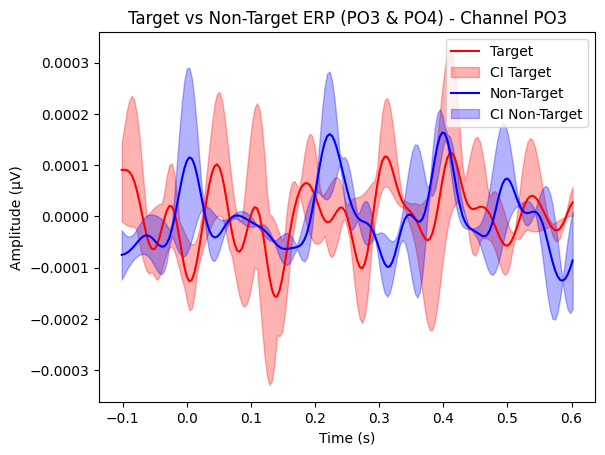

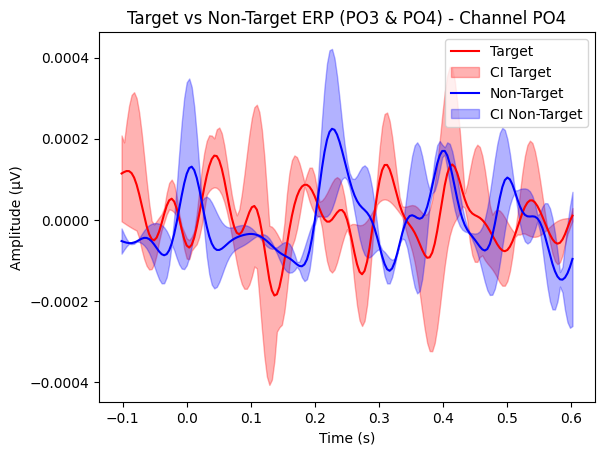

Target Channels: ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']
Non-Target Channels: ['CP3', 'C3', 'F5', 'PO3', 'PO4', 'F6', 'C4', 'CP4']


In [60]:
evoked_target_after = clean_epochs_target.average()  # After rejection (Target)
evoked_nontarget_after = clean_epochs_non_target.average()  # After rejection (Non-Target)

# Function to plot Target vs Non-Target ERP with Confidence Intervals for PO3 and PO4
def plot_target_vs_nontarget_with_ci_po3_po4(evoked_target, evoked_nontarget, epochs_target, epochs_nontarget, title, ci=95):
    """
    Plot Target vs Non-Target ERP with confidence intervals for PO3 and PO4 channels only.
    """
    data_target = epochs_target.get_data(picks=['PO3', 'PO4'])  # Extract target epochs data for PO3 and PO4
    data_nontarget = epochs_nontarget.get_data(picks=['PO3', 'PO4'])  # Extract non-target epochs data for PO3 and PO4
    times = evoked_target.times  # Extract time points

    # Loop through PO3 and PO4 and plot the ERP and Confidence Interval for both target and non-target
    for i, ch_name in enumerate(['PO3', 'PO4']):
        # Compute confidence intervals for Target and Non-Target
        lower_ci_target, upper_ci_target = bootstrap_ci(data_target[:, i, :], ci=ci)
        lower_ci_nontarget, upper_ci_nontarget = bootstrap_ci(data_nontarget[:, i, :], ci=ci)

        # Plot ERP and confidence intervals for both Target and Non-Target for PO3 and PO4
        plt.figure()
        plt.plot(times, evoked_target.data[evoked_target.ch_names.index(ch_name)], label='Target', color='red')
        plt.fill_between(times, lower_ci_target, upper_ci_target, color='red', alpha=0.3, label='CI Target')

        plt.plot(times, evoked_nontarget.data[evoked_nontarget.ch_names.index(ch_name)], label='Non-Target', color='blue')
        plt.fill_between(times, lower_ci_nontarget, upper_ci_nontarget, color='blue', alpha=0.3, label='CI Non-Target')

        plt.title(f'{title} - Channel {ch_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude (µV)')
        plt.legend()
        plt.show()

# Call the function to plot Target vs Non-Target ERP with Confidence Intervals for PO3 and PO4
plot_target_vs_nontarget_with_ci_po3_po4(evoked_target_after, evoked_nontarget_after, clean_epochs_target, clean_epochs_non_target, "Target vs Non-Target ERP (PO3 & PO4)", ci=95)


# Call the function to print the channels from both Target and Non-Target evoked data
print_channels(evoked_target_after, evoked_nontarget_after)

In [61]:
# clfs = OrderedDict()
# clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
# clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
# clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

# clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
# clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


# clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
# clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())
# print(epochs.events[:, -1])

# epochs.pick_types(eeg=True)
# X = epochs.get_data() * 1e6
# times = epochs.times
# y = epochs.events[:, -1]

# # define cross validation
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# # run cross validation for each pipeline
# auc = []
# methods = []
# for m in clfs:
#     res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', cv=cv, n_jobs=-1)
#     auc.extend(res)
#     methods.extend([m]*len(res))

# results = pd.DataFrame(data=auc, columns=['AUC'])
# results['Method'] = methods

# plt.figure(figsize=[8,4])
# sns.barplot(data=results, x='AUC', y='Method')
# plt.xlim(0.2, 0.85)
# sns.despine()
# plt.show()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


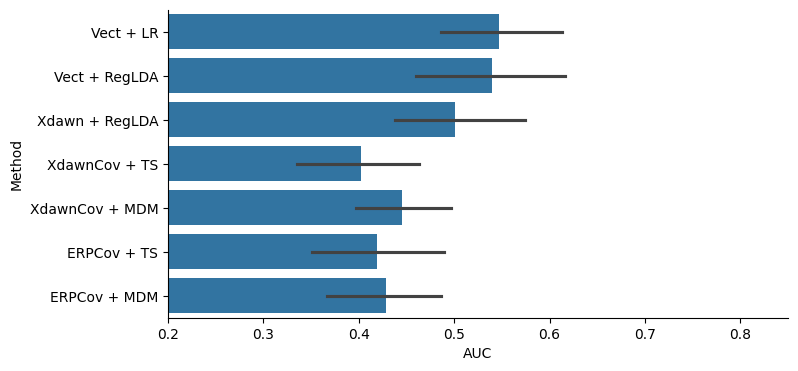

In [62]:

epochs.pick_channels(['PO3', 'PO4'])

# Redefine your data using only the PO3 and PO4 channels
X = epochs.get_data() * 1e6  # Scale to microvolts
y = epochs.events[:, -1]

# Define classifiers (pipelines)
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# Define cross-validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# Run cross-validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y == 2, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m] * len(res))

# Create a results dataframe
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

# Plot the results
plt.figure(figsize=[8, 4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import OrderedDict

# Define frequency range of interest (0-15 Hz)
fmin, fmax = 0, 15

# Split epochs for target and non-target
epochs_target = epochs['Target'].get_data()  # Get raw data for target epochs
epochs_non_target = epochs['Non-Target'].get_data()  # Get raw data for non-target epochs
sfreq = epochs.info['sfreq']  # Sampling frequency

# Function to compute PSD using Welch's method for each epoch and handle multiple channels
def compute_psd_welch(epochs_data, sfreq, fmin, fmax):
    psd_list = []
    for epoch in epochs_data:
        psds = []
        for ch in epoch:  # Loop through each channel
            freqs, psd = welch(ch, sfreq, nperseg=256, noverlap=128)  # Welch's method for each channel
            psds.append(psd[(freqs >= fmin) & (freqs <= fmax)])
        psd_list.append(np.array(psds))  # Collect PSDs for all channels in the epoch
    return np.array(psd_list), freqs[(freqs >= fmin) & (freqs <= fmax)]

# Compute PSD for both target and non-target epochs
psds_target, freqs_target = compute_psd_welch(epochs_target, sfreq, fmin, fmax)
psds_non_target, freqs_non_target = compute_psd_welch(epochs_non_target, sfreq, fmin, fmax)

# Reshape the PSD data from (n_epochs, n_channels, n_freqs) to (n_epochs, n_channels * n_freqs)
psds_target_reshaped = psds_target.reshape(psds_target.shape[0], -1)
psds_non_target_reshaped = psds_non_target.reshape(psds_non_target.shape[0], -1)

# Stack the PSDs together
X = np.vstack([psds_target_reshaped, psds_non_target_reshaped])
y = np.hstack([np.ones(len(psds_target_reshaped)), np.zeros(len(psds_non_target_reshaped))])  # 1 for target, 0 for non-target

# Define classifiers (pipelines)
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(StandardScaler(), LDA(shrinkage='auto', solver='eigen'))

# Define cross-validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

# Run cross-validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m] * len(res))

# Create a results dataframe
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

# Plot the results
plt.figure(figsize=[8, 4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 1.0)
sns.despine()
plt.show()

# Plot PSD for visualization of the frequency bands
plt.figure()
plt.plot(freqs_target, np.mean(psds_target, axis=0), label='Target', color='red')
plt.plot(freqs_non_target, np.mean(psds_non_target, axis=0), label='Non-Target', color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()
